In [1]:
# regression analysis on ames housing data

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


import sklearn.preprocessing as skpp
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn.metrics as skm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
# load data
def load_df():
    # file path
    file_path = './datasets/train.csv'
    # load data
    train = pd.read_csv(file_path)

    return train

train = load_df()
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
# data shape
train.shape

(2051, 81)

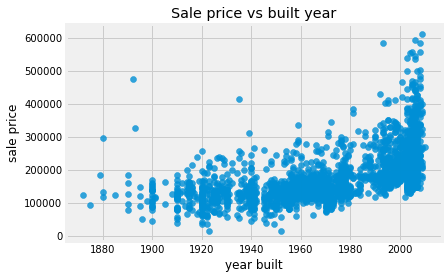

In [5]:
# check basic if the data makes sense
plt.scatter(train['Year Built'], train['SalePrice'], alpha=0.8)
plt.title('Sale price vs built year')
plt.xlabel('year built')
plt.ylabel('sale price')
plt.show()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

# Data Clean

In [7]:
# check the missing values distrubtion in each columns
train.isnull().sum().sort_values(ascending= False).head(20)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
dtype: int64

In [8]:
# fill missing values to all the columns that values are missing
# fill Garage Finish, Garage Qual, Garage Type, Gsmt Cond, Bsmt Qual, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type2, Mas Vnr Type
# above are objects fill with None
# fill  Bsmt Half Bath, Bsmt Full Bath,  Bsmt Unf SF, Total Bsmt SF, Mas Vnr Area, Garage Cars, Garage Area
def process_df():
    
    # drop the columns with so many missing values
    train.drop(columns = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'], inplace = True)

    # fill lot frontage with lot frontage's mean value
    train['Lot Frontage'].fillna(train['Lot Frontage'].mean(), inplace = True)
    # fill objects missing values
    train.fillna(train[['Garage Finish', 'Garage Qual', 'Garage Type', 'Bsmt Cond',
                        'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1','BsmtFin Type 2',
                        'Mas Vnr Type', 'Garage Cond' ]].fillna('None'), inplace = True)

    # fill numeric missing values
    train.fillna(train[['Bsmt Half Bath','Bsmt Full Bath', 'BsmtFin SF 1', 'BsmtFin SF 2', 
                        'Bsmt Unf SF', 'Total Bsmt SF', 'Mas Vnr Area', 
                        'Garage Cars', 'Garage Area']].fillna(0), inplace = True)

    # for these missing values in Garage Yr Blt columns, match with same row of year biult values
    train['Garage Yr Blt'] = train.apply(lambda row: row['Year Built'] if np.isnan(row['Garage Yr Blt']) 
                                         else row['Garage Yr Blt'],axis =1)

    # change garage year built from float to integer
    train['Garage Yr Blt'] = train['Garage Yr Blt'].astype(int)
    
    # add a feature of the house age as predictor
    train['HouseAge'] = train['Yr Sold'] - train['Year Built']
    
    return train

process_df()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,HouseAge
0,109,533352170,60,RL,69.0552,13517,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,130500,34
1,544,531379050,60,RL,43.0000,11492,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,4,2009,WD,220000,13
2,153,535304180,20,RL,68.0000,7922,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,1,2010,WD,109000,57
3,318,916386060,60,RL,73.0000,9802,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2010,WD,174000,4
4,255,906425045,50,RL,82.0000,14235,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2010,WD,138500,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0000,11449,Pave,IR1,HLS,AllPub,...,0,0,0,0,0,1,2008,WD,298751,1
2047,785,905377130,30,RL,69.0552,12342,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,3,2009,WD,82500,69
2048,916,909253010,50,RL,57.0000,7558,Pave,Reg,Bnk,AllPub,...,0,0,0,0,0,3,2009,WD,177000,81
2049,639,535179160,20,RL,80.0000,10400,Pave,Reg,Lvl,AllPub,...,140,0,0,0,0,11,2009,WD,144000,53


In [9]:
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'G

# EDA

Text(0.5, 1.0, 'log price count')

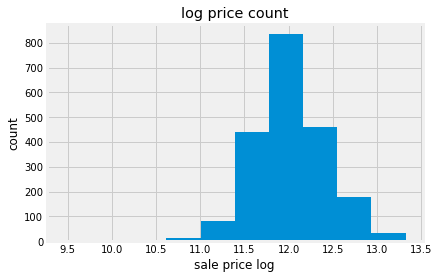

In [10]:
# prepare for the feature 
# Ms zoning, Lot Area, street, Lot shape, Land Contour, Utilities, Land slope, Neigborhood,
# condition2, bldg Type, house style, Overall Qual, HouseAge, Exterior 2, 
# Mas Vnr Type Mas Vnr Area, Exter qual,, foundation, bsmt cond, bsmtFin type 2, bsmtfin sf1,
# total bsmt sf, heating, heatingQC, central air, electrical, 1st Flr SF', '2nd Flr SF',
# 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath' 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
# fireplace, garage type, garage yr blt, garage area, garage qual, wood deck, openporch, 
# enclosed porch, Mo sold, Yr sold, sale type

# transfer sale price to log
train['SalePrice'] = np.log(train['SalePrice'])

plt.hist(train['SalePrice'])
plt.xlabel('sale price log')
plt.ylabel('count')
plt.title('log price count')


Text(0.5, 1.0, 'sale price vs lot area')

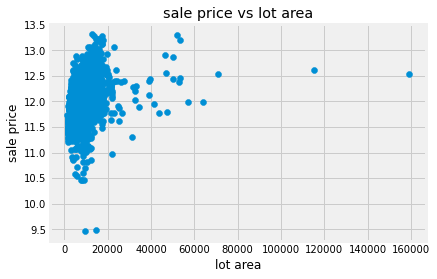

In [11]:
plt.scatter(train['Lot Area'], train['SalePrice'])
plt.ylabel('sale price')
plt.xlabel('lot area')
plt.title('sale price vs lot area')

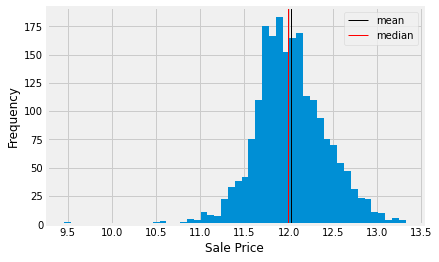

In [12]:
# price 
plt.hist(train['SalePrice'], bins=50)
plt.axvline(train['SalePrice'].mean(), color='k', linewidth=1, label = 'mean')
plt.axvline(train['SalePrice'].median(), color='r', linewidth=1, label = 'median')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.legend()

In [13]:
# kick out the log(price) <10 - outlier
train.drop(train.loc[train['SalePrice'] <10].index, inplace = True)

Text(0, 0.5, 'log sale price')

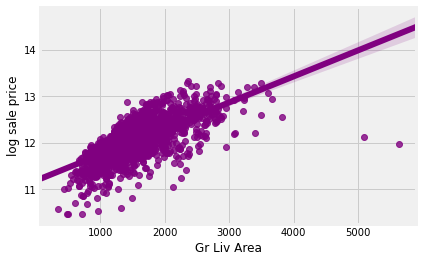

In [14]:
# check the socalled gr live area strong correlation - analysis later
sns.regplot(train['Gr Liv Area'], train['SalePrice'], color='purple')
plt.ylabel('log sale price')

In [15]:
# drop the gr live area > 4000
train.drop(train.loc[train['Gr Liv Area'] > 4000].index, inplace = True)

In [16]:
# create functions to inlcude all the feature, then plot with price in order to check the corr
# categorical features
# referenced code online 
def FP_plot(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/3))
    fig,ax=plt.subplots(nrows=nrows, ncols=3, figsize=(12, 5*nrows))
    ax=ax.ravel()
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # 
    for i, column in enumerate(list_of_columns):
        names = train.groupby(column).mean()['SalePrice'].sort_values().index
        sns.boxplot(x = dataframe[column], y = dataframe['SalePrice'], order = names, ax = ax[i])
        ax[i].set_title(f' SalePrice vs {column}', fontsize = 12)
        ax[i].set_ylabel('price', fontsize=12)
        ax[i].set_xlabel(column, fontsize=12)
        ax[i].set_xticklabels(names,rotation=90)

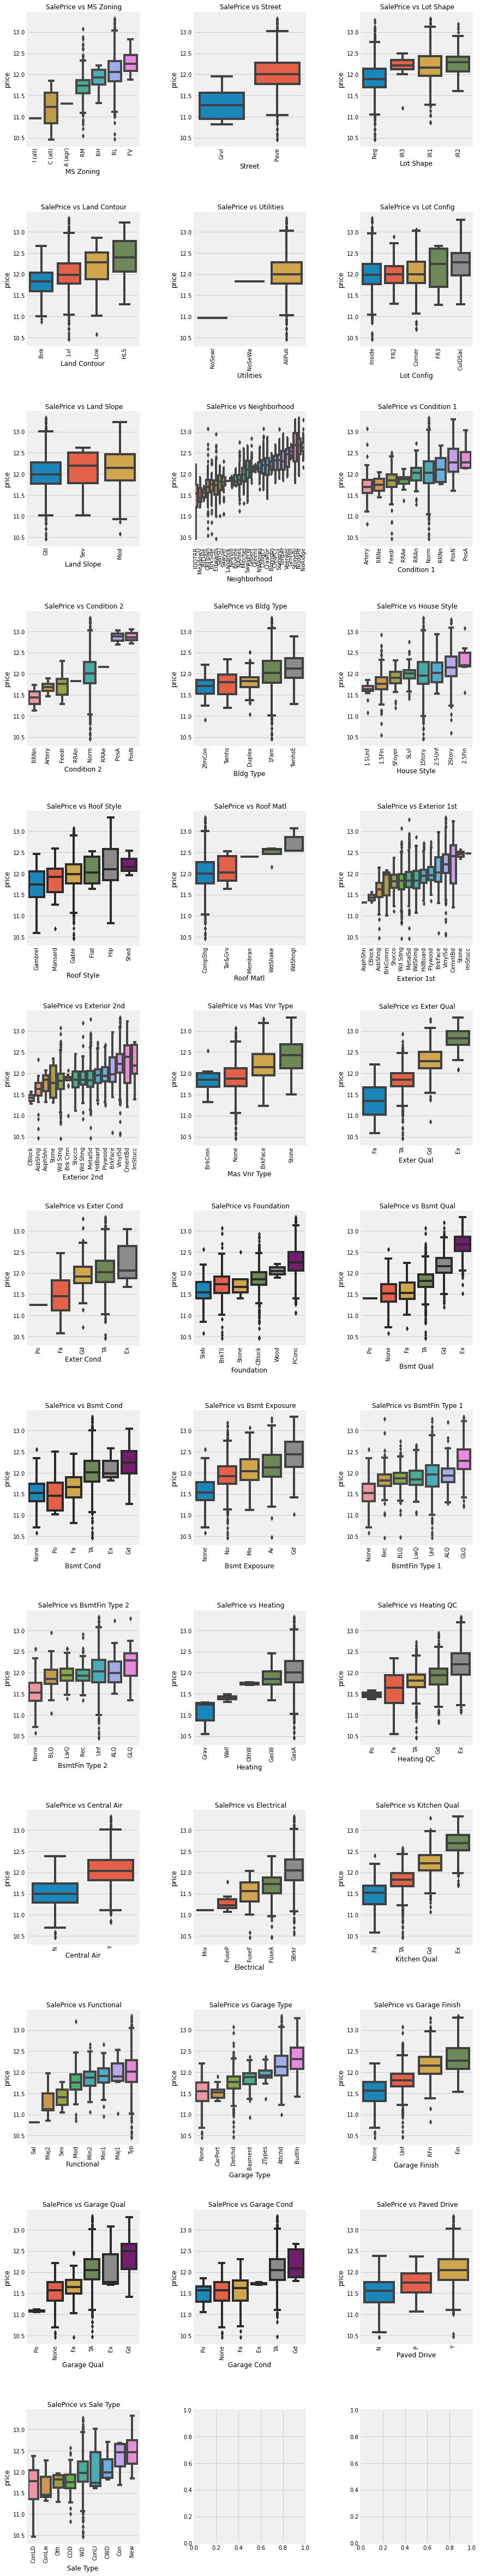

In [17]:
Categories_columns = train.select_dtypes(include = 'object').columns
FP_plot(train, Categories_columns)

In [18]:
# categorical columns
train.select_dtypes(include = 'object').columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'],
      dtype='object')

In [19]:
# use anova test to select features
def anova(dataframe,list_of_columns):
    result =[]
    for i, col in enumerate(list_of_columns):
        mod = ols("dataframe['SalePrice'] ~ dataframe[col]",
                 data=dataframe).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        result.append(aov_table['PR(>F)'][0])
    return result


# anova analysis on variables for further selection
p = list(np.around(np.array(anova(train, Categories_columns)),4)) 
v = Categories_columns
a=list(zip(v,p))
list(filter(lambda x: x[1] >0.05, a))

[('Land Slope', 0.0715)]

In [20]:
# remove utilities and land slope columns p-value > 0.05
train.drop(['Utilities','Land Slope'], axis=1, inplace= True)


# drop features are redudant
# drop lot shape, lot config, land slope, roof style, heating
# combine condition 1 and 2 if possible, combine exterior 1 and 2, Bsmtfin type 1 and 2
# drop condition 2, exterior 2, Bsmtfin 2

train.drop(['Lot Shape', 'Lot Config', 'Roof Style', 'Heating', 
           'Condition 2','Exterior 2nd', 'BsmtFin Type 2'], axis=1, inplace= True)

# numeric features , check if any corr() values < 0.15, consider as weak association
# can always adjust the corr() values to include features
abs(train.corr()['SalePrice']) < 0.15

# drop numeric columns
# PID, ID - nothing to do with the model
# pool area - no pool
# drop | corr() score| less than 0.15  
# drop MS SubClass, overall cond, BsmtFin SF 2, Low Qual Fin SF, Bsmt Half Bath ,
# Bedroom AbvGr , Kitchen AbvGr , Enclosed Porch ,3Ssn Porch ,Screen Porch,Pool Area,
# Misc Val , mo sold, yr sod

# drop these numeric columns
train.drop(['PID', 'Id', 'Pool Area', 'MS SubClass','Overall Cond', 'BsmtFin SF 2', 
            'Low Qual Fin SF', 'Bsmt Half Bath' , 'Bedroom AbvGr', 'Kitchen AbvGr',
           'Enclosed Porch','3Ssn Porch','Screen Porch', 'Misc Val', 'Mo Sold', 'Yr Sold'], 
          axis=1, inplace = True)

# we have to do features engineering on numerical that are not rational for modeling
# combine '''1st Flr SF', '2nd Flr SF' - as Flr SF
# Combine columns' 'bsmt full bath, full bath, halth bath' to object
train['Flr SF'] = train['1st Flr SF'] + train['2nd Flr SF']
train['Bath'] = train['Bsmt Full Bath'] + train['Full Bath'] + train['Half Bath']
# comibne 'wood deck sf, and open porch sf' - as Attach SF
train['Attach SF'] = train['Wood Deck SF'] + train['Open Porch SF']
# combine lot frontage and lot area
train['Lot SF'] = train['Lot Frontage'] + train['Lot Area']

# remove Year Built since we have HouseAge columns
# drop 'Bsmt unf sf' since there is total bsmt sf
# drop Garage Yr Blt
# And drop all the columns used for combination
train.drop(columns = ['Year Built', 'Bsmt Unf SF', 'Garage Yr Blt', '1st Flr SF',
                     '2nd Flr SF', 'Bsmt Full Bath', 'Full Bath', 'Half Bath',
                     'Wood Deck SF', 'Open Porch SF', 'Lot Frontage', 'Lot Area'], axis=1, inplace = True)

In [21]:
# numerical features, and objective features
# numerical features
train.select_dtypes(include = [np.number]).columns,

(Index(['Overall Qual', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1',
        'Total Bsmt SF', 'Gr Liv Area', 'TotRms AbvGrd', 'Fireplaces',
        'Garage Cars', 'Garage Area', 'SalePrice', 'HouseAge', 'Flr SF', 'Bath',
        'Attach SF', 'Lot SF'],
       dtype='object'),)

In [22]:
# categorical columns
train.select_dtypes(include = 'object').columns

Index(['MS Zoning', 'Street', 'Land Contour', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Matl', 'Exterior 1st', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Sale Type'],
      dtype='object')

In [24]:
train.corr()['SalePrice'].sort_values()

HouseAge         -0.630354
Lot SF            0.293901
BsmtFin SF 1      0.431465
Attach SF         0.442642
Mas Vnr Area      0.453582
Fireplaces        0.495708
TotRms AbvGrd     0.503741
Year Remod/Add    0.605027
Bath              0.653303
Total Bsmt SF     0.659142
Garage Area       0.672460
Garage Cars       0.682241
Gr Liv Area       0.713879
Flr SF            0.723846
Overall Qual      0.825880
SalePrice         1.000000
Name: SalePrice, dtype: float64

In [25]:
# one hot encoder the categorical columns
train.select_dtypes(include = 'object').columns

train = pd.get_dummies(columns =['MS Zoning', 'Street', 'Land Contour', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Matl', 'Exterior 1st', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Sale Type'], data=train, drop_first = True)

In [26]:
train.shape

(2047, 173)

# Do the same processing on test data

In [27]:
# import clean test data, already dummified
test = pd.read_csv('./datasets/clean_test.csv')

train.shape, test.shape
# now the training and testing features are different
# get rid of features are not in both set

((2047, 173), (878, 166))

In [28]:
y = train['SalePrice']
missingFeatures = list(set(train.columns.values) - set(test.columns.values))
train = train.drop(missingFeatures, axis=1)  # drop train features

missingFeatures = list(set(test.columns.values) - set(train.columns.values))
test = test.drop(missingFeatures, axis=1) # drop test features

train.shape, test.shape

((2047, 158), (878, 158))

Modeling

In [29]:
# Train/test split your data.
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=42, test_size=.25)

In [30]:
# feature scalling
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# OLS LinearRegression

In [31]:
#arguably, the real challenge in such cases is to be sure that you compare apples to apples. And in your case, it seems that you don't. Our best friend is always the relevant documentation, combined with simple experiments. So...
#Although scikit-learn's LinearRegression() (i.e. your 1st R-squared) is fitted by default with fit_intercept=True (docs), this is not the case with statsmodels' OLS (your 2nd R-squared); quoting from the docs:
#An intercept is not included by default and should be added by the user. See statsmodels.tools.add_constant.# Linear Regression

# statsmodels
# first artificially add intercept to X, as advised in the docs:
#X_ = sm.add_constant(X)

#model = sm.OLS(y,X_) # X_ here
#results = model.fit()
#results.rsquared


X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=42, test_size=.25)
X_ = sm.add_constant(X_train)    # add x intercept columns becaue ols defualt no intercept
sm_model = OLS(endog= y_train, exog = X_)

sm_model = sm_model.fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:17:54   Log-Likelihood:                 1389.2
No. Observations:                1535   AIC:                            -2472.
Df Residuals:                    1382   BIC:                            -1656.
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.6274      0.457     16.695      0.000       6.731       8.524
Overall Qual             0.0528      0.004     12.567      0.000       0.045       0.061
Year Remod/Add           0.0014      0.000      6.575      0.000       0.001       0.002
Mas Vnr Area          1.516e-05   2.49e-05      0.608      0.543   -3.37e-05    6.41e-05
BsmtFin SF 1          5.573e-05   1.12e-05      4.991      0.000    3.38e-05    7.76e-05
Total Bsmt SF         9.966e-05   1.51e-05      6.594      0.000       7e-05       0.000
Gr Liv Area              0.0002   6.06e-05      2.756      0.006    4.82e-05       0.000
TotRms AbvGrd            0.0043      0.004      1.207      0.228      -0.003       0.011
Fireplaces               0.0240      0.006      4.169      0.000       0.013       0.035
Garage Cars              0.0129      0.010      1.291      0.197      -0.007       0.032
Garage Area           9.631e-05   3.43e-05      2.805      0.005     2.9e-05       0.000
HouseAge                -0.0009      0.000     -3.308      0.001      -0.001      -0.000
Flr SF                8.212e-05   5.91e-05      1.390      0.165   -3.37e-05       0.000
Bath                     0.0166      0.005      3.143      0.002       0.006       0.027
Attach SF             6.636e-05   2.33e-05      2.853      0.004    2.07e-05       0.000
Lot SF                2.501e-06   5.67e-07      4.411      0.000    1.39e-06    3.61e-06
MS Zoning_FV             0.2440      0.048      5.040      0.000       0.149       0.339
MS Zoning_I (all)        0.0541      0.124      0.436      0.663      -0.189       0.298
MS Zoning_RH             0.2502      0.056      4.441      0.000       0.140       0.361
MS Zoning_RL             0.2104      0.041      5.173      0.000       0.131       0.290
MS Zoning_RM             0.1709      0.039      4.373      0.000       0.094       0.248
Street_Pave              0.0504      0.051      0.995      0.320      -0.049       0.150
Land Contour_HLS        -0.0132      0.022     -0.603      0.546      -0.056       0.030
Land Contour_Low        -0.0194      0.027     -0.722      0.470      -0.072       0.033
Land Contour_Lvl        -0.0042      0.016     -0.270      0.787      -0.035       0.027
Neighborhood_Blueste    -0.0074      0.054     -0.138      0.891      -0.114       0.099
Neighborhood_BrDale     -0.0893      0.046     -1.935      0.053      -0.180       0.001
Neighborhood_BrkSide    -0.0165      0.036     -0.456      0.649      -0.088       0.055
Neighborhood_ClearCr    -0.0045      0.037     -0.122      0.903      -0.077       0.068
Neighborhood_CollgCr    -0.0430      0.028     -1.513      0.131      -0.099       0.013
Neighborhood_Crawfor     0.0893      0.033      2.690      0.007       0.024       0.154
Neighborhood_Edwards    -0.0971      0.031     -3.109    

In [32]:
# linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9399908466933058, 0.8989640682616913)

In [33]:
# Define the model
l_model = LinearRegression()
# fit the model
l_model.fit(X_train, y_train)

LinearRegression()

<AxesSubplot:title={'center':'Linear Regression Model'}, xlabel='Predicted price', ylabel='SalePrice'>

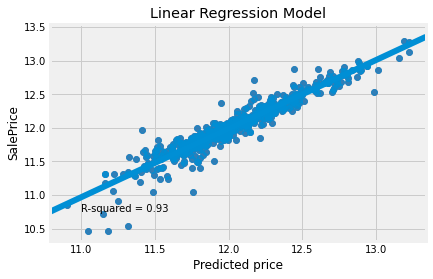

In [34]:
train_preds = lr.predict(X_test)
train_preds.shape
r_squared= 0.93
plt.scatter(train_preds, y_test, alpha=0.75, color='r')
plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title('Linear Regression Model')
plt.text(11, 10.75, 'R-squared = %0.2f' % r_squared)
# sns.set_theme(color_codes=True)
sns.regplot(train_preds, y_test)

In [41]:
#Use Zip to See lr Coefficients beside our columns, replace with each instance
pd.DataFrame(list(zip(train.columns,lr.coef_))).rename(columns = {0: 'features', 1: 'coefficients with price'})

,features,coefficients with price
0,Overall Qual,0.052808
1,Year Remod/Add,0.001438
2,Mas Vnr Area,0.000015
3,BsmtFin SF 1,0.000056
4,Total Bsmt SF,0.000100
...,...,...
153,Sale Type_ConLI,0.011627
154,Sale Type_ConLw,0.096732
155,Sale Type_New,0.096615
156,Sale Type_Oth,0.143672


# Ridge

In [42]:
# instantiate and fit model
ridge_model = Ridge(alpha =10)
ridge_model.fit(X_train, y_train)
# Evaluate model using R2.
print('Training Ridge Score',ridge_model.score(X_train, y_train))
print('Test Ridge Score',ridge_model.score(X_test, y_test))

Training Ridge Score 0.9346789503876216
Test Ridge Score 0.9023453814813689


In [43]:
# Cross-validate over our list of ridge alphas.
r_alphas = np.linspace(0, 10, 100)
ridge_cv = RidgeCV(alphas = r_alphas, scoring = 'r2', cv=5)
ridge_cv.fit(X_train, y_train)

print('ridge cv alpha:', ridge_cv.alpha_)
print('Train RidgeCV Score:',ridge_cv.score(X_train, y_train))
print('Test RidgeCV Score:',ridge_cv.score(X_test, y_test))

ridge cv alpha: 4.94949494949495
Train RidgeCV Score: 0.9368300846468351
Test RidgeCV Score: 0.9019938835514085


# Lasso

In [44]:
# instantiate and fit model
# alphas = 0 best
lasso_model = Lasso(alpha =0)
lasso_model.fit(X_train, y_train)
# Evaluate model using R2.
print('Training Lasso Score',lasso_model.score(X_train, y_train))
print('Test Lasso Score',lasso_model.score(X_test, y_test))

l_alphas = np.linspace(0,2, 100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
lasso_cv.fit(X_train, y_train)

/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_30206/553200020.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(X_train, y_train)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.353862661359002, tolerance: 0.024509136536957268
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_

Training Lasso Score 0.9399908466765434
Test Lasso Score 0.8989641638195849


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.727333330885699, tolerance: 0.019833575870800913
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.843866731858924, tolerance: 0.019118306617745336
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexp

LassoCV(alphas=array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061...
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494949,
       1.51515152, 1.53535354, 1.55555556, 1.57575758, 1.5959596 ,
       1.61616162, 1.63636364, 1.65656566, 1.67676768, 1.6969697 ,
       1.71717172, 1.73737374, 1.75757576, 1.77777778, 1.7979798 ,
       1.81818182, 1.83838384, 1.85858586, 1.87878788, 1.8989899 ,
       1.91919192, 1.93939394, 1.95959596, 1.97979798, 2.        ]),
        cv=5, max_iter=50000)

In [45]:
print('lasso_cv alpha', lasso_cv.alpha_)
print('Train Lasso Score:',lasso_cv.score(X_train, y_train))
print('Test Lasso Score:',lasso_cv.score(X_test, y_test))

lasso_cv alpha 0.0
Train Lasso Score: 0.9399908466933058
Test Lasso Score: 0.8989640682617137


# ElasticNet Regression

In [46]:
# instantiate and fit model
Enet_model = ElasticNet(alpha =2)
Enet_model.fit(X_train, y_train)
# Evaluate model using R2.
print('Training Enet Score',Enet_model.score(X_train, y_train))
print('Test Enet Score',Enet_model.score(X_test, y_test))

Training Enet Score 0.8311778323519916
Test Enet Score 0.8018190313927118


In [47]:
Enet_alphas = np.linspace(0.5, 1.0, 100)
Enet_ratio = 0.95
Enet_model = ElasticNetCV(alphas = Enet_alphas, l1_ratio = Enet_ratio, cv=5)
Enet_model = Enet_model.fit(X_train, y_train)

# adjusted alphas and ratio, almost like lasso model
print('elastic net regression alpha', Enet_model.alpha_)
print(Enet_model.score(X_train, y_train))
print(Enet_model.score(X_test, y_test))

elastic net regression alpha 0.5
0.8451523632391718
0.8237486833999439


# Random Forest

In [53]:
# initiate the model

rf_model = RandomForestRegressor(random_state = 42)
# fit the model
rf_model.fit(X_train, y_train)

y_preds = rf_model.predict(X_test)

print("Random Forest".center(18, "="))
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))


# directly calculate the RMSE
print('Random Forest RMSE: ', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds))))

==Random Forest===
0.9846959076478049
0.878616832655227
Random Forest RMSE:  25401.72646884723


# XGBoost

In [54]:
# initiate the model

xgb_model = xgb.XGBRegressor(learning_rate = 0.1, 
                             max_depth = 5, 
                             alpha = 10, 
                             n_estimators = 100,
                             random_state = 42)
# fit the model
xgb_model.fit(X_train, y_train)

y_preds = xgb_model.predict(X_test)


print("XGBoost".center(18, "="))
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

# directly calculate the RMSE
print('XGBoost RMSE: ', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds))))

=====XGBoost======
0.9233090353962546
0.871349257274084
XGBoost RMSE:  29708.010792703266


In [55]:
# Comparation 
print('R2 Score in Each Model\ntrain\ntest')
print()
print(" LR ".center(18, "="))
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))
print()
print(" Ridge ".center(18, "="))
print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))
print()
print(" Lasso ".center(18, "="))
print(lasso_model.score(X_train, y_train))
print(lasso_model.score(X_test, y_test))
print()
print(" ElasticNet ".center(18, "="))
print(Enet_model.score(X_train, y_train))
print(Enet_model.score(X_test, y_test))

print("Random Forest".center(18, "="))
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))

print("XGBoost".center(18, "="))
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))

R2 Score in Each Model
train
test

======= LR =======
0.9399908466933058
0.8989640682616913

===== Ridge ======
0.9033007961434114
0.9337089173396167

===== Lasso ======
0.9399908466765434
0.8989641638195849

=== ElasticNet ===
0.8451523632391718
0.8237486833999439
==Random Forest===
0.9846959076478049
0.878616832655227
=====XGBoost======
0.9233090353962546
0.871349257274084


RIDGE RMSE:  18179.70650627767


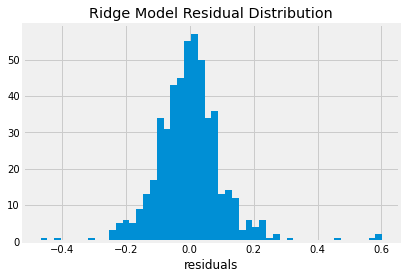

In [49]:
# Ridge model high score
# choose Ridge regression to do the prediction
# alphas already optimized  4.94949494949495
ridge_model = Ridge(alpha =4.95)
ridge_model.fit(X_test, y_test)

y_preds = ridge_model.predict(X_test)

residuals = y_preds - y_test
# from sklearn.metrics import mean_squared_error
plt.hist(residuals, bins=50)
plt.xlabel('residuals')
plt.title('Ridge Model Residual Distribution')

# use ridge regression model 
# transform log rmse back to rmse
from sklearn.metrics import mean_squared_error
print('RIDGE RMSE: ', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds))))

In [50]:
print('number of features used: {}'.format(np.sum(ridge_model.coef_!=0)))

number of features used: 149


# create new submission

In [86]:
test_id = pd.read_csv('./datasets/test.csv')
submission = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': lasso_model.predict(test)}, index= None)
submission.reset_index(drop=True, inplace=True)

In [88]:
# change log price to price
submission['SalePrice'] = np.exp(submission['SalePrice'])

# sale price round to 2 decimals
submission['SalePrice'] = submission['SalePrice'].round(decimals=2)

In [89]:
submission.head()

,Id,SalePrice
0,2658,93437.14
1,2718,165576.76
2,2414,213391.69
3,1989,106941.06
4,625,170241.14


In [90]:
submission.shape

(878, 2)

In [91]:
submission.to_csv('./datasets/kaggle_lasso_submission.csv')

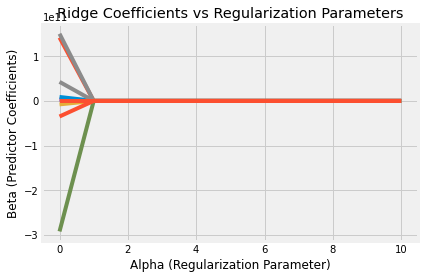

In [109]:
###initialize list to store coefficient values
coef=[]
alphas = range(0,11)

for a in alphas:
    ridge_model = Ridge(alpha=a)
    ridge_model.fit(X_train, y_train)
    coef.append(ridge_model.coef_)
    
###Make plot of Beta as a function of Alpha
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')
###ax.legend(loc='best')
fig.savefig('coef_vs_alpha.png')